In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip3 install torch torchvision pandas transformers scikit-learn tensorflow numpy seaborn matplotlib textwrap3 sentencepiece

In [3]:
!ls gdrive/MyDrive/data_image

california_wildfires  hurricane_irma   iraq_iran_earthquake  srilanka_floods
hurricane_harvey      hurricane_maria  mexico_earthquake


In [4]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
import transformers
from transformers import get_linear_schedule_with_warmup
from torchvision import transforms
import torch
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image

def clean_text(text):
    text = re.sub(r"@[A-Za-z0-9_]+", ' ', text)
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    text = re.sub(r"[^a-zA-z.,!?'0-9]", ' ', text)
    text = re.sub('\t', ' ',  text)
    text = re.sub(r" +", ' ', text)
    return text

def label_to_target(text):
  if text == "informative":
    return 1
  else:
    return 0

df_train = pd.read_csv("./gdrive/MyDrive/ColabNotebooks/train.tsv", sep='\t')
df_train = df_train[['image', 'label_text']]
df_train = df_train.sample(frac=1, random_state = 24).reset_index(drop=True)
df_train['label_text'] = df_train['label_text'].apply(label_to_target)

df_val = pd.read_csv("./gdrive/MyDrive/ColabNotebooks/val.tsv", sep='\t')
df_val = df_val[['image', 'label_text']]
df_val = df_val.sample(frac=1, random_state = 24).reset_index(drop=True)
df_val['label_text'] = df_val['label_text'].apply(label_to_target)

df_test = pd.read_csv("./gdrive/MyDrive/ColabNotebooks/test.tsv", sep='\t')
df_test = df_test[['image', 'label_text']]
df_test = df_test.sample(frac=1, random_state = 24).reset_index(drop=True)
df_test['label_text'] = df_test['label_text'].apply(label_to_target)


In [6]:
data_dir = "./gdrive/MyDrive/"
class DisasterTweetDataset(Dataset):

  def __init__(self, paths, targets):
    self.paths = paths
    self.targets = targets
    self.transform = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
  
  def __len__(self):
    return len(self.paths)
  
  def __getitem__(self, item):
    path = str(self.paths[item])
    target = self.targets[item]

    img = Image.open(data_dir+self.paths[item]).convert('RGB')
    img = self.transform(img)  

    return {
      'tweet_image': img,
      'targets': torch.tensor(target, dtype=torch.long)
    }

def create_data_loader(df, batch_size):
  ds = DisasterTweetDataset(
    paths=df.image.to_numpy(),
    targets=df.label_text.to_numpy(),
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )


class TweetClassifier(nn.Module):

  def __init__(self):
    super(TweetClassifier, self).__init__()
    self.densenet = torchvision.models.densenet161(pretrained=True)
    # for param in self.resnext.parameters():
    #   param.requires_grad = False

    self.linear1 = nn.Linear(1000, 256)
    self.relu    = nn.ReLU()
    self.dropout = nn.Dropout(p=0.4)
    self.linear2 = nn.Linear(256, 1)
    self.sigmoid = nn.Sigmoid()
  
  def forward(self, tweet_img):
    output = self.densenet(tweet_img)
    linear1_output = self.linear1(output)
    relu_output = self.relu(linear1_output)
    dropout_output = self.dropout(relu_output)
    linear2_output = self.linear2(dropout_output)
    probas = self.sigmoid(linear2_output)
    return probas


def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    tweet_imgs = d["tweet_image"].to(device)
    targets = d["targets"].reshape(-1, 1).float()
    targets = targets.to(device)

    outputs = model(
      tweet_img = tweet_imgs
    )


    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(torch.round(outputs) == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      tweet_imgs = d["tweet_image"].to(device)
      targets = d["targets"].reshape(-1, 1).float()
      targets = targets.to(device)

      outputs = model(
        tweet_img = tweet_imgs
      )

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(torch.round(outputs) == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [7]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, BATCH_SIZE)


model = TweetClassifier()
model = model.to(device)

EPOCHS = 40

optimizer = optim.AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.BCELoss().to(device)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


In [8]:
history = defaultdict(list)
start_epoch = 0
best_accuracy = -1

# checkpoint = torch.load("./gdrive/MyDrive/Models/Densenet/checkpoint.t7")
# model.load_state_dict(checkpoint['state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# start_epoch = checkpoint['epoch']

# print(start_epoch)
# print(checkpoint['best_accuracy'])


for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    state = {
            'best_accuracy': val_acc,
            'epoch': start_epoch+epoch+1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
    }
    savepath= "./gdrive/MyDrive/Models/Densenet/checkpoint.t7"
    torch.save(state,savepath)
    best_accuracy = val_acc

Epoch 1/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.41617253100951246 accuracy 0.8115821268617852
Val   loss 0.3472689478844404 accuracy 0.8442466624284807

Epoch 2/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.20387751257597805 accuracy 0.9229246953442349
Val   loss 0.41907860038802025 accuracy 0.8378893833439288

Epoch 3/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0730616560134653 accuracy 0.9771898760545776
Val   loss 0.6909712540553301 accuracy 0.8385251112523839

Epoch 4/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.03553158806071194 accuracy 0.9920841579002186
Val   loss 0.9672106402025383 accuracy 0.8493324856961221

Epoch 5/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.02185920522583502 accuracy 0.996771169669826
Val   loss 1.232481684647646 accuracy 0.8442466624284807

Epoch 6/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.013059416491534612 accuracy 0.9980210394750546
Val   loss 1.268951507034635 accuracy 0.8283534647171011

Epoch 7/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.01508761555703926 accuracy 0.9991667534631808
Val   loss 1.445082741809565 accuracy 0.8340750158931978

Epoch 8/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.008601919459893465 accuracy 0.9992709092802833
Val   loss 1.480407326624554 accuracy 0.831532104259377

Epoch 9/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.008250696449778444 accuracy 0.9996875325486928
Val   loss 1.4490821631572361 accuracy 0.8347107438016529

Epoch 10/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.006367697667932577 accuracy 0.9995833767315905
Val   loss 1.4864367904076972 accuracy 0.8429752066115702

Epoch 11/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.002851119805428271 accuracy 0.9996875325486928
Val   loss 1.5151419754625 accuracy 0.8417037507946599

Epoch 12/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0029274226104519696 accuracy 0.9995833767315905
Val   loss 1.773229590282408 accuracy 0.8385251112523839

Epoch 13/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0010068592985291928 accuracy 0.9997916883657952
Val   loss 1.869894684792207 accuracy 0.8461538461538461

Epoch 14/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.001978937468705957 accuracy 0.9995833767315905
Val   loss 1.7018951286418451 accuracy 0.831532104259377

Epoch 15/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0006704809264493237 accuracy 0.9997916883657952
Val   loss 1.8069837917241967 accuracy 0.8397965670692944

Epoch 16/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0001198237267337777 accuracy 1.0
Val   loss 1.834924671173403 accuracy 0.8378893833439288

Epoch 17/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 5.493184267661309e-05 accuracy 1.0
Val   loss 1.7867002542622321 accuracy 0.8410680228862047

Epoch 18/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 9.278754272340575e-06 accuracy 1.0
Val   loss 1.8612325644494285 accuracy 0.8397965670692944

Epoch 19/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 1.019655871215698e-05 accuracy 1.0
Val   loss 1.8697800939977856 accuracy 0.8417037507946599

Epoch 20/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 5.660525088451111e-06 accuracy 1.0
Val   loss 1.9332430681288588 accuracy 0.8391608391608392

Epoch 21/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 4.2890487514853815e-06 accuracy 1.0
Val   loss 1.943239358738083 accuracy 0.8391608391608392

Epoch 22/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 3.460908392403545e-06 accuracy 1.0
Val   loss 2.0541646554768214 accuracy 0.8391608391608392

Epoch 23/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 4.09081238524247e-06 accuracy 1.0
Val   loss 2.06327025017143 accuracy 0.8385251112523839

Epoch 24/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 2.877036774068899e-06 accuracy 1.0
Val   loss 2.071889476567512 accuracy 0.8385251112523839

Epoch 25/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 2.7414601102685406e-06 accuracy 1.0
Val   loss 2.1318598039448307 accuracy 0.8397965670692944

Epoch 26/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 2.842847832111588e-06 accuracy 1.0
Val   loss 2.1438022670894883 accuracy 0.8391608391608392

Epoch 27/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 2.5211055636516502e-06 accuracy 1.0
Val   loss 2.1484997668415335 accuracy 0.8391608391608392

Epoch 28/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 1.7596600803654457e-06 accuracy 1.0
Val   loss 2.1562110427171013 accuracy 0.8404322949777495

Epoch 29/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 1.7368603789134303e-06 accuracy 1.0
Val   loss 2.1620527833551186 accuracy 0.8397965670692944

Epoch 30/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 1.513874034149095e-06 accuracy 1.0
Val   loss 2.1688818191289916 accuracy 0.8397965670692944

Epoch 31/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 1.4809179786993242e-06 accuracy 1.0
Val   loss 2.17617452196777 accuracy 0.8404322949777495

Epoch 32/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 1.1731036229658129e-06 accuracy 1.0
Val   loss 2.183595735400916 accuracy 0.8404322949777495

Epoch 33/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 1.2212574498201688e-06 accuracy 1.0
Val   loss 2.1895072176009425 accuracy 0.8404322949777495

Epoch 34/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 1.1573250629229305e-06 accuracy 1.0
Val   loss 2.1951046699881562 accuracy 0.8410680228862047

Epoch 35/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 1.1448530056400862e-06 accuracy 1.0
Val   loss 2.2000188908278946 accuracy 0.8410680228862047

Epoch 36/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 9.0604123083735e-07 accuracy 1.0
Val   loss 2.204000748574734 accuracy 0.8410680228862047

Epoch 37/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 9.380283492797114e-07 accuracy 1.0
Val   loss 2.206867838084698 accuracy 0.8404322949777495

Epoch 38/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 7.710998354713788e-07 accuracy 1.0
Val   loss 2.2093753595203167 accuracy 0.8404322949777495

Epoch 39/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 9.414178827944095e-07 accuracy 1.0
Val   loss 2.211447841480375 accuracy 0.8404322949777495

Epoch 40/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 8.992197222877406e-07 accuracy 1.0
Val   loss 2.2116476963758473 accuracy 0.8404322949777495



In [9]:
state = {
        'epoch': start_epoch + EPOCHS,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
}
savepath= "./gdrive/MyDrive/Models/Densenet/checkpoint-{}.t7".format(start_epoch + EPOCHS)
torch.save(state,savepath)

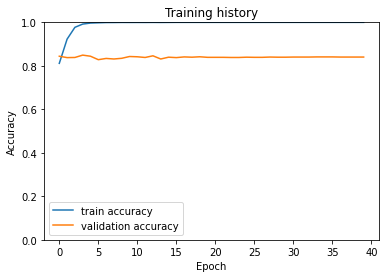

In [10]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [11]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  predictions = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      tweet_imgs = d["tweet_image"].to(device)
      targets = d["targets"].reshape(-1, 1).float()
      targets = targets.to(device)

      outputs = model(tweet_img=tweet_imgs)
      preds = torch.round(outputs)


      predictions.extend(preds)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, real_values

y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

print(classification_report(y_test, y_pred, target_names=['Not Informative', 'Informative']))

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


                 precision    recall  f1-score   support

Not Informative       0.79      0.75      0.77       504
    Informative       0.88      0.90      0.89      1030

       accuracy                           0.85      1534
      macro avg       0.84      0.83      0.83      1534
   weighted avg       0.85      0.85      0.85      1534

